In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [2]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

In [3]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

In [4]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3) # This is CU
    repetitions *= 2
qpe.draw()

┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────
     └───┘                                                               
c: 3/════════════════════════════════════════════════════════════════════

In [5]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Swaps shouldn't be forgotten
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [6]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n, n)
qpe.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ ┌─┐      
«q_0: ┤ H ├─■──────────────■────────────────────────░─┤M├──────
«     └───┘ │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─────────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                             └───┘ ░  ║  ║ └╥┘
«q_3: ──────────────────────────────────────────────░──╫──╫──╫─
«                                                   ░  ║  ║  ║ 
«c: 3/═════════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

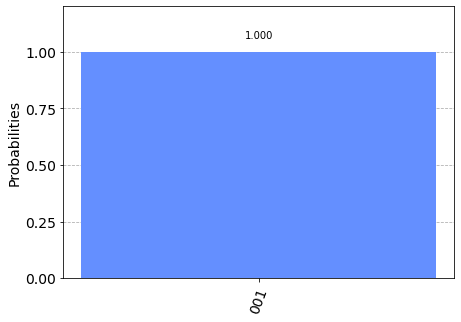

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [8]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)
    
# Prepare our eigenstate |psi>
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3)
    repetitions *= 2
    
# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)
    
qpe2.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                  ┌───┐                                   ┌─┐           
«q_0: ───────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
«                │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐   
«q_1: ───────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├───
«                │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
«q_2: ─■─────────X──────────────────────■─────────■─────────╫─┤ H ├─╫─┤M├
«      │P(2π/3)                                             ║ └───┘ ║ └╥┘
«q_3: ─■────────────────────────────────────────────────────╫───────╫──╫─
«                                                           ║       ║  ║ 
«c: 3/══════════════════════════════════════════════════════╩═══════╩══╩═
«                                                           0       1  2

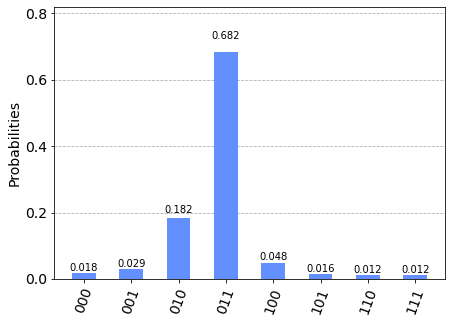

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
qobj = assemble(t_qpe2, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [10]:
# Create and set up circuit for more precise calculation
qpe3 = QuantumCircuit(6, 5)

# Apply H-gates to counting qubits
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5)
    repetitions *= 2
    
# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure

qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
    
qpe3.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │         │         │         │         │         │        »
q_4: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_5: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │         │         │         │         │         │         │        »
«q_4: ─┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ────────────────────────X─────────────────────────────────────────────»
«                             │                                             »
«q_2: ────────────────────────┼─────────────────────────────────────────────»
«                             │                                             »
«q_3: ─■─────────■────────────X─────────────────────────────────────────────»
«      │         │                                                          »
«q_4: ─┼─────────┼─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─────────────────────────────────

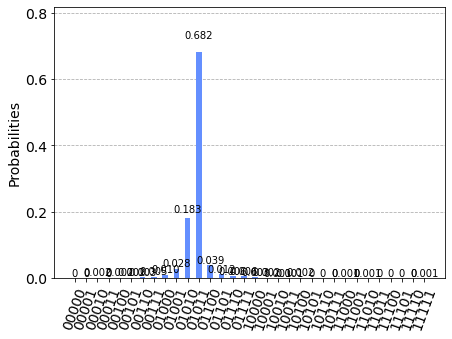

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
qobj = assemble(t_qpe3, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [17]:
IBMQ.load_account()
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                      and not x.configuration().simulator
                                     and x.status().operational==True))
print("least busy backend: ", backend)



ibmqfactory.load_account:WARNING:2022-07-20 04:05:54,915: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila


In [18]:
shots = 2048
t_qpe = transpile(qpe, backend, optimization_level=3)
job = backend.run(t_qpe, shots=shots)
job_monitor(job)

Job Status: job has successfully run


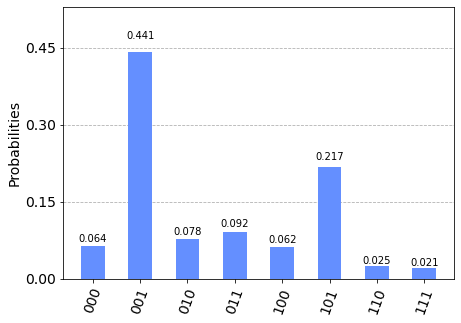

In [19]:
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)